---
# content reconstruction

---

### Import libraries and set up environment

In [1]:
import torch
from torch import nn, tensor
import torch.optim as optim

from torchvision.models.vgg import vgg19, VGG19_Weights
from torchvision import transforms

from PIL import Image

constants

In [2]:
IMAGE_PATH = "../data/dog.jpg"

RANDOM_SEED = 42
TARGET_LAYERS = [0, 5]
LR = 0.01
NUM_ITERATION = 100

Set up model

In [3]:
weights = VGG19_Weights.DEFAULT
model = vgg19(weights=weights)
model.eval()
transform = weights.transforms()

In [4]:
model.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

Freeze the VGG model parameters

In [5]:
for param in model.parameters():
    param.requires_grad = False

In [6]:
image = Image.open(IMAGE_PATH)

## content reconstruction

In [7]:
image_t = transform(image)
batch = image_t.unsqueeze(0)
print(image_t.shape)

torch.Size([3, 224, 224])


In [8]:
image_t.requires_grad

False

In [9]:
def generate_white_noise_image(
    width,
    height,
):
    white_noise_image = torch.randn(1, 3, width, height)
    white_noise_image = transform(white_noise_image)
    white_noise_image.requires_grad = True
    return white_noise_image

In [10]:
def tensor_to_image(image_t):
    return transforms.Compose([transforms.ToPILImage()])(image_t.squeeze(0).cpu().clone().detach())

In [11]:
white_noise_image_t = generate_white_noise_image(224, 224)
print(white_noise_image_t.requires_grad)

True


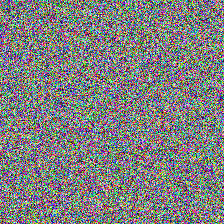

In [12]:
tensor_to_image(white_noise_image_t)

In [13]:
def get_features(model, x):
    """
    forward pass and get the features for some target layer
    """
    features = []
    features = {}
    for i, layer in enumerate(model.features):
        x = layer(x)
        features[i] = x
    return features

Loss function

In [14]:
def loss_content(white_noise_features, real_image_features, layer):
    white_noise_features_for_layer = white_noise_features[layer]
    real_image_features_for_layer = real_image_features[layer]
    loss = nn.MSELoss()(white_noise_features_for_layer, real_image_features_for_layer)
    return loss

Optimization loop

In [15]:
def reconstruct_content(
    generated_image,  # white noise image
    real_image_features,
    layer,
    num_iteration=NUM_ITERATION,
):
    optimizer = optim.Adam([generated_image], lr=LR)
    for i in range(num_iteration):
        optimizer.zero_grad()

        generated_image_features = get_features(model, generated_image)
        # Calculate loss
        loss = loss_content(real_image_features, generated_image_features, layer)

        # Backward pass
        loss.backward()

        # Update the image
        optimizer.step()

        # Clip the values to be in the valid range
        with torch.no_grad():
            generated_image.data.clamp_(0, 1)

        print(f"Iteration {i+1}/{num_iteration}, Loss: {loss.item()}")
    new_generated_image = tensor_to_image(generated_image)
    return new_generated_image

In [16]:
real_image_features = get_features(model, image_t)
generated_image = reconstruct_content(white_noise_image_t, real_image_features, layer=0)

/home/cuphead/Projects/artististic-style-morpher/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 64, 224, 224])) that is different to the input size (torch.Size([64, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 1/100, Loss: 9.940486907958984
Iteration 2/100, Loss: 0.3244834244251251
Iteration 3/100, Loss: 0.3198949992656708
Iteration 4/100, Loss: 0.3156213164329529
Iteration 5/100, Loss: 0.3115071952342987
Iteration 6/100, Loss: 0.3074905276298523
Iteration 7/100, Loss: 0.30354344844818115
Iteration 8/100, Loss: 0.2996530830860138
Iteration 9/100, Loss: 0.2958115041255951
Iteration 10/100, Loss: 0.2920134961605072
Iteration 11/100, Loss: 0.28825843334198
Iteration 12/100, Loss: 0.2845447361469269
Iteration 13/100, Loss: 0.2808716297149658
Iteration 14/100, Loss: 0.27724069356918335
Iteration 15/100, Loss: 0.2736513614654541
Iteration 16/100, Loss: 0.2701020836830139
Iteration 17/100, Loss: 0.26659390330314636
Iteration 18/100, Loss: 0.2631273567676544
Iteration 19/100, Loss: 0.2597021460533142
Iteration 20/100, Loss: 0.2563183009624481
Iteration 21/100, Loss: 0.25297656655311584
Iteration 22/100, Loss: 0.2496763914823532
Iteration 23/100, Loss: 0.24641799926757812
Iteration 24/100, 

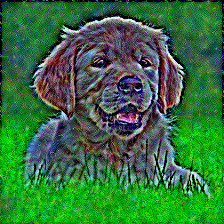

In [17]:
generated_image

In [20]:
white_noise_image_t_2 = generate_white_noise_image(224, 224)
generated_image_2 = reconstruct_content(
    white_noise_image_t_2, real_image_features, layer=5, num_iteration=100
)

/home/cuphead/Projects/artististic-style-morpher/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 128, 112, 112])) that is different to the input size (torch.Size([128, 112, 112])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 1/100, Loss: 111.70279693603516
Iteration 2/100, Loss: 3.643683671951294
Iteration 3/100, Loss: 3.5619258880615234
Iteration 4/100, Loss: 3.4811596870422363
Iteration 5/100, Loss: 3.4011709690093994
Iteration 6/100, Loss: 3.322157859802246
Iteration 7/100, Loss: 3.2443840503692627
Iteration 8/100, Loss: 3.168065071105957
Iteration 9/100, Loss: 3.0933756828308105
Iteration 10/100, Loss: 3.02044677734375
Iteration 11/100, Loss: 2.949388265609741
Iteration 12/100, Loss: 2.880268096923828
Iteration 13/100, Loss: 2.8131392002105713
Iteration 14/100, Loss: 2.748081684112549
Iteration 15/100, Loss: 2.6850898265838623
Iteration 16/100, Loss: 2.6241564750671387
Iteration 17/100, Loss: 2.5652658939361572
Iteration 18/100, Loss: 2.5083818435668945
Iteration 19/100, Loss: 2.453449249267578
Iteration 20/100, Loss: 2.400454044342041
Iteration 21/100, Loss: 2.3493099212646484
Iteration 22/100, Loss: 2.2999789714813232
Iteration 23/100, Loss: 2.2523670196533203
Iteration 24/100, Loss: 2.2063

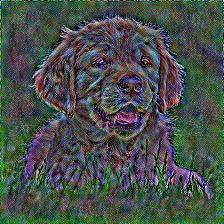

In [21]:
generated_image_2

as we noticed the higher the layer is (5 in contrast with 0) the less the content reconstruction constrain the exact pixel values (only the content).